<a href="https://colab.research.google.com/github/neeha-23/myportfolio.github.io/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from math import log2

In [4]:
# Load dataset
def load_data(file_path):
    data = pd.read_csv(file_path, header=None, na_values='?')
    return data

In [8]:
# Load and preprocess data
training_data = load_data('/content/training.data')
test_data = load_data('/content/test.data')

X_train, y_train = split_features_labels(training_data)
X_test, y_test = split_features_labels(test_data)

X_train = handle_missing_values(X_train, X_train)
X_test = handle_missing_values(X_test, X_train)

# Train trees with cross-validation
c45_tree = cross_validate(X_train, y_train, build_c45_tree)
cart_tree = cross_validate(X_train, y_train, build_cart_tree)

# Evaluate on test set
c45_predictions = [predict(c45_tree, row) for _, row in X_test.iterrows()]
cart_predictions = [predict(cart_tree, row) for _, row in X_test.iterrows()]

# Compute metrics
c45_metrics = compute_metrics(y_test, c45_predictions)
cart_metrics = compute_metrics(y_test, cart_predictions)

Before handling missing values:
  0      1       2  3  4   5   6      7  8  9   10 11 12     13    14
0  b  16.92   0.335  y  p   k   v  0.290  f  f   0  f  s  200.0     0
1  b  48.50   4.250  u  g   m   v  0.125  t  f   0  t  g  225.0     0
2  a  68.67  15.000  u  g   e   z  0.000  t  t  14  f  g    0.0  3376
3  a  25.08   2.540  y  p  aa   v  0.250  t  f   0  t  g  370.0     0
4  b  33.75   2.750  u  g   i  bb  0.000  f  f   0  f  g  180.0     0
Column: 0, Filled Missing Value: b
Column: 1, Filled Missing Value: 29.17
Column: 2, Filled Missing Value: 2.7925
Column: 3, Filled Missing Value: u
Column: 4, Filled Missing Value: gg
Column: 5, Filled Missing Value: j
Column: 6, Filled Missing Value: j
Column: 7, Filled Missing Value: 1.0
Column: 8, Filled Missing Value: t
Column: 9, Filled Missing Value: t
Column: 10, Filled Missing Value: 0.0
Column: 11, Filled Missing Value: t
Column: 12, Filled Missing Value: p
Column: 13, Filled Missing Value: 160.0
Column: 14, Filled Missing Value: 2.

In [5]:
# Split attributes and labels
def split_features_labels(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    return X, y

# Handle missing values using median for numerical and sorted median for categorical
def handle_missing_values(X, X_train):
    print("Before handling missing values:")
    print(X.head())
    for col in X.columns:
        if X[col].dtype == 'object':
            sorted_values = sorted(X_train[col].dropna().unique())
            median_value = sorted_values[len(sorted_values) // 2] if sorted_values else None
        else:
            median_value = X_train[col].median()
        X[col] = X[col].fillna(median_value)
        print(f"Column: {col}, Filled Missing Value: {median_value}")  # Debugging line
    print("After handling missing values:")
    print(X.head())
    return X

In [6]:
# Entropy calculation
def entropy(y):
    counts = Counter(y)
    total = len(y)
    return -sum((count/total) * log2(count/total) for count in counts.values() if count > 0)

# Information gain calculation
def information_gain(X, y, feature):
    """Calculates the information gain for a given feature."""
    total_entropy = entropy(y)
    weighted_entropy = 0
    for value in X[feature].unique():
        subset_y = y[X[feature] == value]
        weighted_entropy += (len(subset_y) / len(y)) * entropy(subset_y)
    return total_entropy - weighted_entropy

# Information gain ratio for C4.5
def information_gain_ratio(X, y, feature):
    gain = information_gain(X, y, feature) # Now, this call works!
    split_info = entropy(X[feature])
    return gain / split_info if split_info != 0 else gain
# Gini index for CART
def gini_index(y):
    counts = Counter(y)
    total = len(y)
    return 1 - sum((count/total) ** 2 for count in counts.values())

In [7]:
# Implement C4.5 (basic structure)
def build_c45_tree(X, y):
    if len(set(y)) == 1:
        return y.iloc[0]
    best_feature = max(X.columns, key=lambda feature: information_gain_ratio(X, y, feature))
    tree = {best_feature: {}}
    for value in X[best_feature].unique():
        subtree_X = X[X[best_feature] == value].drop(columns=[best_feature])
        subtree_y = y[X[best_feature] == value]
        tree[best_feature][value] = build_c45_tree(subtree_X, subtree_y)
    return tree

# Implement CART (basic structure using Gini index)
def build_cart_tree(X, y):
    if len(set(y)) == 1:
        return y.iloc[0]
    best_feature = min(X.columns, key=lambda feature: gini_index(y[X[feature].notnull()]))
    tree = {best_feature: {}}
    for value in X[best_feature].unique():
        subtree_X = X[X[best_feature] == value].drop(columns=[best_feature])
        subtree_y = y[X[best_feature] == value]
        tree[best_feature][value] = build_cart_tree(subtree_X, subtree_y)
    return tree

In [13]:
# Function to visualize the tree
def print_tree(tree, depth=0):
    if not isinstance(tree, dict):
        print("  " * depth, "->", tree)
        return
    for key, value in tree.items():
        print("  " * depth, key)
        for subkey, subtree in value.items():
            print("  " * (depth + 1), subkey)
            print_tree(subtree, depth + 2)

# Manual 10-fold cross-validation
def cross_validate(X, y, build_tree_func):
    fold_size = len(X) // 10
    best_tree, best_f1 = None, 0
    for i in range(10):
        start, end = i * fold_size, (i + 1) * fold_size
        X_val, y_val = X.iloc[start:end], y.iloc[start:end]
        X_train = pd.concat([X.iloc[:start], X.iloc[end:]])
        y_train = pd.concat([y.iloc[:start], y.iloc[end:]])
        tree = build_tree_func(X_train, y_train)
        predictions = [predict(tree, row) for _, row in X_val.iterrows()]
        accuracy, precision, recall, f1 = compute_metrics(y_val, predictions)
        if f1 > best_f1:
            best_tree, best_f1 = tree, f1
    return best_tree

# Prediction function
def predict(tree, row):
    if not isinstance(tree, dict):
        return tree
    feature = next(iter(tree))
    value = row[feature]
    return predict(tree[feature].get(value, list(tree[feature].values())[0]), row)

In [17]:
print("C4.5 Decision Tree:")
print_tree(c45_tree)
print("\nCART Decision Tree:")
print_tree(cart_tree)

C4.5 Decision Tree:
 8
   f
     12
       s
         10
           0
             14
               0
                 3
                   y
                     -> -
                   u
                     6
                       v
                         -> -
                       bb
                         -> -
                       h
                         1
                           30.67
                             -> -
                           45.0
                             -> -
                           35.17
                             -> +
                           30.33
                             -> -
                       ff
                         -> -
                       j
                         -> +
                   l
                     -> +
               1
                 -> +
               27
                 -> -
           11
             -> -
           1
             -> +
       g
         14
           0
             1
        

In [18]:
# Compute evaluation metrics
def compute_metrics(y_true, y_pred):
    tp = sum(1 for yt, yp in zip(y_true, y_pred) if yt == '+' and yp == '+')
    tn = sum(1 for yt, yp in zip(y_true, y_pred) if yt == '-' and yp == '-')
    fp = sum(1 for yt, yp in zip(y_true, y_pred) if yt == '-' and yp == '+')
    fn = sum(1 for yt, yp in zip(y_true, y_pred) if yt == '+' and yp == '-')
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1# Plot results
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
c45_values = list(c45_metrics)
cart_values = list(cart_metrics)

In [14]:
# Output results
print("C4.5 Decision Tree:")
print("Accuracy:", c45_metrics[0])
print("Precision:", c45_metrics[1])
print("Recall:", c45_metrics[2])
print("F1 Score:", c45_metrics[3])

print("\nCART Decision Tree:")
print("Accuracy:", cart_metrics[0])
print("Precision:", cart_metrics[1])
print("Recall:", cart_metrics[2])
print("F1 Score:", cart_metrics[3])

print("\nComparison: C4.5 performs better" if c45_metrics[3] > cart_metrics[3] else "\nComparison: CART performs better")

C4.5 Decision Tree:
Accuracy: 0.8785714285714286
Precision: 0.8285714285714286
Recall: 0.9206349206349206
F1 Score: 0.8721804511278196

CART Decision Tree:
Accuracy: 0.5571428571428572
Precision: 0.5054945054945055
Recall: 0.7301587301587301
F1 Score: 0.5974025974025974

Comparison: C4.5 performs better


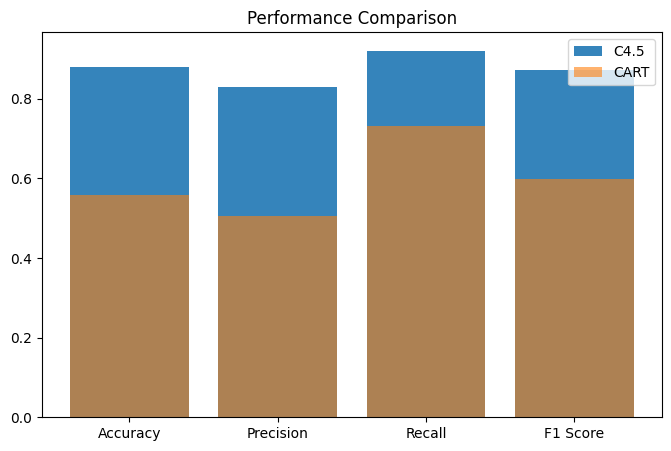

In [21]:
plt.figure(figsize=(8, 5))
plt.bar(labels, c45_values, alpha=0.9, label='C4.5')
plt.bar(labels, cart_values, alpha=0.6, label='CART')
plt.legend()
plt.title('Performance Comparison')
plt.show()